In [83]:
import matplotlib.pyplot as plt
# Compute correlation
from pathlib import Path, PurePath
import sys
import numpy as np
import matplotlib
# Find path to root folder
rootFolder = 'sounds-phd'
pathToRoot = Path().resolve()
while PurePath(pathToRoot).name != rootFolder:
    pathToRoot = pathToRoot.parent
sys.path.append(f'{pathToRoot}/01_algorithms/01_NR/02_distributed')
from danse_utilities.setup import apply_sro_sto
%matplotlib inline
matplotlib.style.use('default')  # <-- for Jupyter: white figures background

fs = 16000                   # sampling frequency [samples/s] (true sampling rate)
dur = 5                    # signal duration [s]
# nSignals = 18
nSignals = 5
srosToTest = np.linspace(0,100,nSignals)   # SRO [ppm] 
srosToTest = np.insert(srosToTest, 0, 0)
signalType = 'noise'
signalType = 'speech'
delayFromReference = 0.1    # delay between microphones and reference signal [s]
# delayFromReference = 0    # delay between microphones and reference signal [s]

sensorToNodeTags = np.arange(1, nSignals+2)
nSamples = int(fs * dur)        # total number of samples
t = np.arange(nSamples) / fs
seed = 12345
rng = np.random.default_rng(seed)

Generate raw signals

Resampling x to 16000 samples/s.


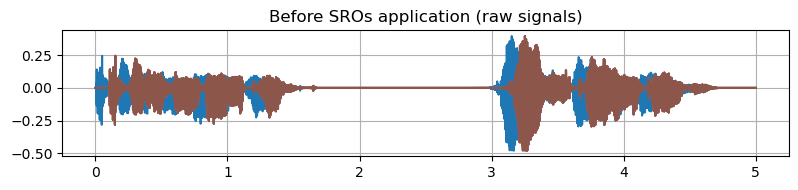

In [84]:
import soundfile as sf
from scipy import signal as sig
import copy

if signalType == 'noise':
    x1 = rng.uniform(-.5,.5,size=(len(t),1))
elif signalType == 'speech':
    x1, fsImport = sf.read('./test_sound.wav')
    # Truncate
    x1 = x1[:int(fsImport*dur), np.newaxis]
    if fsImport != fs:
        print(f'Resampling x to {fs} samples/s.')
        x1 = sig.resample(x1, axis=0, num=int(fs * dur))
x = np.repeat(x1, nSignals + 1, 1)

# Apply delays
if delayFromReference > 0:
    nSamplesDelay = int(delayFromReference * fs)
    for ii in range(1, nSignals + 1):
        xCopy = copy.copy(x[:, ii])
        x[:nSamplesDelay, ii] = 0
        x[nSamplesDelay:, ii] = xCopy[:-nSamplesDelay]

# Show signals
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax.plot(t, x)
ax.grid()
ax.set_title('Before SROs application (raw signals)')
plt.tight_layout()	
plt.show()


Apply SROs

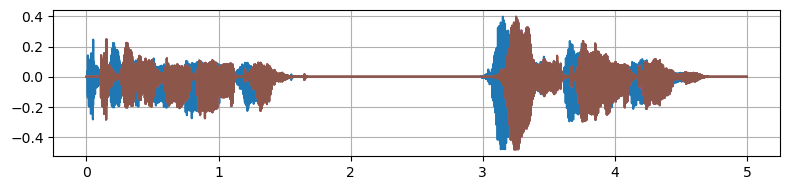

In [85]:
# APPLY SROs
x_out, t_out, fssro = apply_sro_sto(x, fs, sensorToNodeTags, srosToTest, STOinducedDelays=np.zeros_like(srosToTest), plotit=False)

# Test plot
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax.plot(t_out, x_out)
# ax.plot(x_out[:,3])
# ax.plot(x_out[10000:10100,2], 'k')
# ax.plot(x_out[10000:10100,3], 'r')
ax.grid()
# ax.set_title('After SROs application')
plt.tight_layout()	
plt.show()

if 0:
    fig.savefig(f'./figs/SROs/onCorrelations/waveforms_{signalType}.png')
    fig.savefig(f'./figs/SROs/onCorrelations/waveforms_{signalType}.pdf')

Compute correlations and compare them

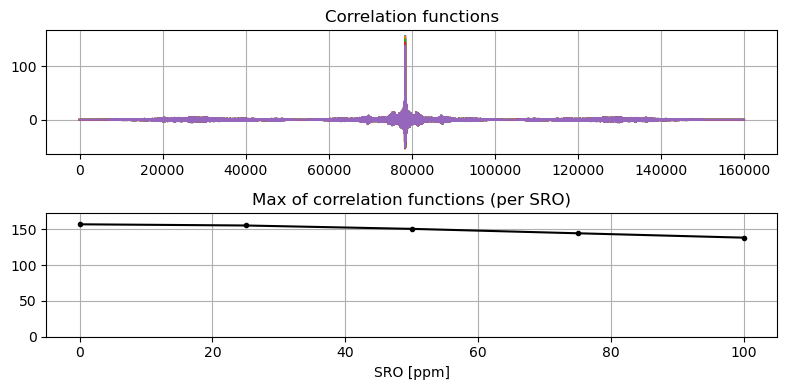

In [86]:
# COMPUTE CORRELATIONS
# chunkSize = 1000     # size of chunk to slide across the original, 0 ppm SRO, signal
correlationPeaks = np.zeros(nSignals + 1)
# r = np.zeros((x_out.shape[0] - chunkSize + 1, nSignals + 1))
r = np.zeros((2*x_out.shape[0]-1, nSignals))
for ii in range(nSignals):
    r[:, ii] = sig.correlate(x_out[:,0], x_out[:,ii+1]) 
    correlationPeaks[ii] = np.amax(r[:, ii])


fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(211)
ax.plot(r)
ax.grid()
ax.set_title('Correlation functions')
ax = fig.add_subplot(212)
ax.plot(srosToTest[1:], correlationPeaks[:-1], 'k.-')
ax.grid()
ax.set_title('Max of correlation functions (per SRO)')
ax.set_xlabel('SRO [ppm]')
ax.set_ylim([0, 1.1*np.amax(correlationPeaks)])
plt.tight_layout()

if 1:
    fig.savefig(f'./figs/SROs/onCorrelations/corrfcns_{signalType}.png')
    fig.savefig(f'./figs/SROs/onCorrelations/corrfcns_{signalType}.pdf')
    

Compute batch-mode "spatial" cross-correlations

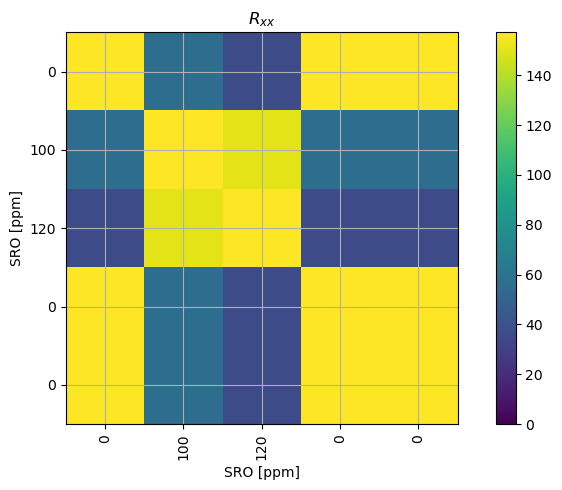

In [87]:
# COMPUTE BATCH MODE "SPATIAL" CROSS-CORRELATIONS

srosToTestRxx = np.zeros(nSignals + 1)
srosToTestRxx[2] = 100
srosToTestRxx[3] = 120
# APPLY SROs
x_out, t_out, fssro = apply_sro_sto(x, fs, sensorToNodeTags, srosToTestRxx, STOinducedDelays=np.zeros_like(srosToTestRxx), plotit=False)
srosToTestRxx = srosToTestRxx[1:]

Rxx = np.dot(x_out[:, 1:].T, x_out[:, 1:].conj())

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
mapp = ax.imshow(Rxx, vmin=0)
ax.grid()
ax.set_title('$R_{xx}$')
ax.set_xlabel('SRO [ppm]')
ax.set_ylabel('SRO [ppm]')
plt.xticks(np.arange(nSignals), labels=[f'{int(srosToTestRxx[ii])}' for ii in range(nSignals)], rotation='vertical')
plt.yticks(np.arange(nSignals), labels=[f'{int(srosToTestRxx[ii])}' for ii in range(nSignals)], rotation='horizontal')
plt.colorbar(mapp)
plt.tight_layout()

Compute online-mode "spatial" cross-correlations via exponential averaging

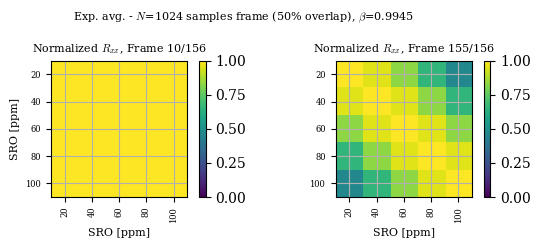

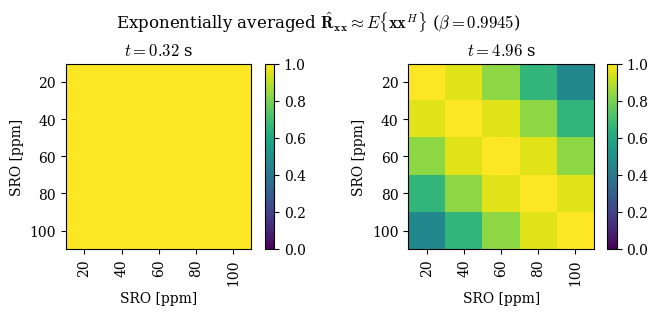

In [95]:
# COMPUTE ONLINE (EXP. AVERAGING) MODE "SPATIAL" CROSS-CORRELATIONS
# hfont = {'fontname':'Arial'}]
plt.rcdefaults()
plt.style.use('U:/py/sounds-phd/95_style_sheets/plot1.mplstyle')

srosToTestRxx = np.zeros(nSignals + 1)
title = 'noSROs'
srosToTestRxx[2] = 100
srosToTestRxx[3] = 120
# title = 'outlierNodes'
srosToTestRxx = np.linspace(0, 100, num=nSignals+1)
title = 'linspaceSROs'
# APPLY SROs
x_out, t_out, fssro = apply_sro_sto(x, fs, sensorToNodeTags, srosToTestRxx, STOinducedDelays=np.zeros_like(srosToTestRxx), plotit=False)
srosToTestRxx = srosToTestRxx[1:]

# Plot parameters
nMaps = 2
RxxForPlot = np.empty((nSignals, nSignals, 0))

frameSize = 2**10
ovlp = 0.5
beta = 0.9945   # exp. averaging update constant
nNewSamplesPerFrame = int(frameSize * (1 - ovlp))
nFrames = int(np.floor(x_out.shape[0] / nNewSamplesPerFrame))
# idxFramesForPlot = int(nFrames / nMaps) * np.arange(1,nMaps+1) - 1
idxFramesForPlot = [10]
if nMaps > 2:
    for ii in range(nMaps - 2):
        idxFramesForPlot.append(int(nFrames / (nMaps - 1)) * (ii + 1))
idxFramesForPlot.append(nFrames - 1)
for l in range(nFrames):
    idxBeg = l * nNewSamplesPerFrame
    idxEnd = idxBeg + frameSize
    xCurr = x_out[idxBeg:idxEnd, 1:]
    if l == 0:
        Rxx = np.dot(xCurr.T, xCurr.conj())
    else:
        Rxx = beta * Rxx + (1 - beta) * np.dot(xCurr.T, xCurr.conj())

    if l in idxFramesForPlot:
        RxxForPlot = np.concatenate((RxxForPlot, Rxx[:, :, np.newaxis]), axis=2)
    
# PLOT -- for LaTeX journal week 11 2022
fig = plt.figure(figsize=(3*nMaps,3/5*4))
for ii in range(nMaps):
    ax = fig.add_subplot(100 + nMaps * 10 + ii + 1)
    mapp = ax.imshow(RxxForPlot[:,:,ii] / np.amax(RxxForPlot[:,:,ii]), vmin=0, vmax=1)
    if nSignals < 20:
        ax.grid()
    ax.set_xlabel('SRO [ppm]', size=8)
    if ii == 0:
        ax.set_ylabel('SRO [ppm]', size=8)
    ax.set_title(f'Normalized $R_{{xx}}$, Frame {idxFramesForPlot[ii]}/{nFrames}', size=8)
    plt.xticks(np.arange(nSignals), labels=[f'{int(srosToTestRxx[ii])}' for ii in range(nSignals)], rotation='vertical', size=6)
    plt.yticks(np.arange(nSignals), labels=[f'{int(srosToTestRxx[ii])}' for ii in range(nSignals)], rotation='horizontal', size=6)
    plt.colorbar(mapp)
plt.suptitle(f'Exp. avg. - $N$={frameSize} samples frame ({int(100 * ovlp)}% overlap), $\\beta$={beta}', size=8)
plt.tight_layout()

if 0:
    fig.savefig(f'./figs/SROs/onCorrelations/out_{title}_{signalType}.png')
    fig.savefig(f'./figs/SROs/onCorrelations/out_{title}_{signalType}.pdf')

# PLOT -- for IWAENC 1-slider / SOUNDS blog post [see TUE in Word journal week26, 2022]
fig2 = plt.figure(figsize=(7,3))
for ii in range(nMaps):
    ax = fig2.add_subplot(100 + nMaps * 10 + ii + 1)
    mapp = ax.imshow(RxxForPlot[:,:,ii] / np.amax(RxxForPlot[:,:,ii]), vmin=0, vmax=1)
    ax.set_xlabel('SRO [ppm]')#, size=8)
    # if ii == 0:
    ax.set_ylabel('SRO [ppm]')#, size=8)
    # ax.set_title(f'Frame {idxFramesForPlot[ii]}/{nFrames}')#, size=8)
    ax.set_title(f'$t={idxFramesForPlot[ii] * nNewSamplesPerFrame / fs}$ s')
    plt.xticks(np.arange(nSignals), labels=[f'{int(srosToTestRxx[ii])}' for ii in range(nSignals)], rotation='vertical')#, size=8)
    plt.yticks(np.arange(nSignals), labels=[f'{int(srosToTestRxx[ii])}' for ii in range(nSignals)], rotation='horizontal')#, size=8)
    plt.colorbar(mapp)
plt.suptitle(f'Exponentially averaged $\\hat{{\\mathbf{{R}}}}_\\mathbf{{xx}} \\approx E\\{{\\mathbf{{xx}}^H\\}}$ ($\\beta={beta}$)')
plt.tight_layout()

if 1:
    fig2.savefig(f'./figs/SROs/onCorrelations/out_{title}_{signalType}_forBlog.png')
    fig2.savefig(f'./figs/SROs/onCorrelations/out_{title}_{signalType}_forBlog.pdf')

In [89]:
matplotlib.get_cachedir()

print(matplotlib.rcParams['font.serif'])

['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']
